# Spike Train Analysis: Exercise 3 - Higher Order Correlations

This notebook covers the following topics:

* Higher-order correlations; Compound Poisson Process as a model of population correlations
* Complexity distribution
* Analysis of higher order correlations with the SPADE method

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import quantities as pq
import elephant.spike_train_surrogates as surr
import elephant.statistics as stats
import elephant.spike_train_generation as stocmod
import elephant.spade as spade

%matplotlib inline

# Task 3: Higher-order correlations

## 3.1 Compound Poisson Process (CPP)

The Compund Poisson Process (CPP) is a versatile model of parallel spike trains correlated by a well-defined correlation structure. Here, we use the CPP to generate various types of correlated data, that we will later analyse.

### Exercise

* Generate correlated parallel spike trains (e.g. 100) by means of the CPP (see `help(stocmod.cpp)`). 
* Plot the data: are correlations visible in the raster plot by eye? 
* Plot also the population histogram and the histogram of its values (the *complexity distribution*): is the correlation visible there? Try different firing rates and amplitude distributions.
* Discuss the role of the amplitude distribution in determining the correlation structure among the parallel spike trains.
* Discuss the relation between the amplitude distribution and the complexity distribution.

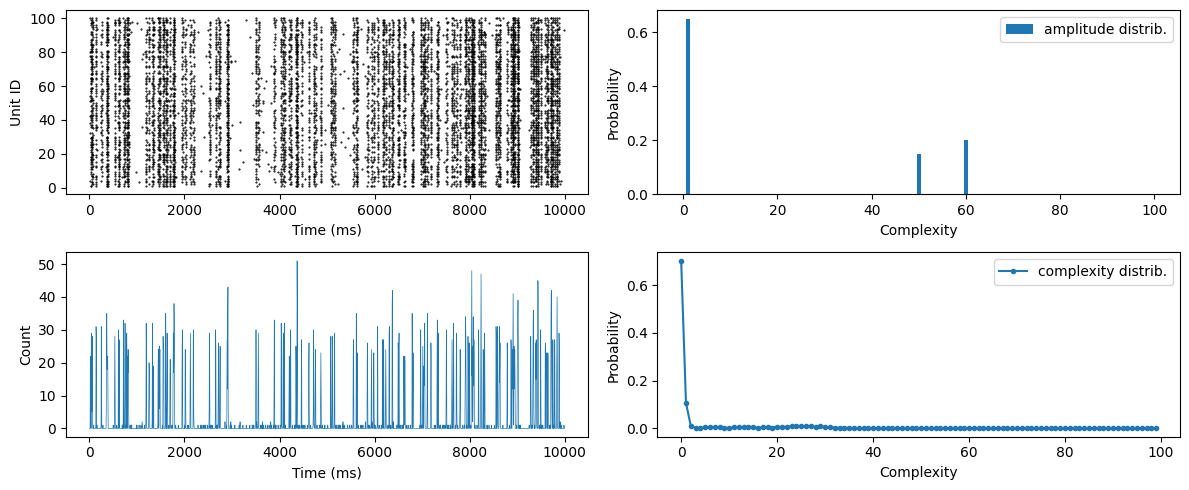

In [67]:
# Spike train parameters
num_units = 100      
rate = 10 * pq.Hz 
trial_duration = 10 * pq.s
# - parameters for the CPP model
assembly_size = 50
assembly_size1 =60
p_coinc = 0.15
p_coinc1 =0.2
jitter = 5 * pq.ms

# Analysis parameters
binsize = 5 * pq.ms

# Construct the amplitude distribution for the CPP
amp_dist = np.zeros(num_units + 1) 
amp_dist[1] = 1. - p_coinc - p_coinc1
amp_dist[assembly_size], amp_dist[assembly_size1] = p_coinc, p_coinc1
#amp_dist[assembly_size] = p_coinc

# Generate the CPP data
cpp = stocmod.cpp(rate, amp_dist, trial_duration, shift=jitter)

# Compute the population histogram and the complexity distribution
complexity_cpp = stats.Complexity(cpp, bin_size=binsize, binary=True)
pophist = complexity_cpp.time_histogram
dist_cpp = complexity_cpp.pdf().flatten().magnitude
dist_cpp = np.concatenate([dist_cpp, np.zeros(num_units - len(dist_cpp))])

# Plot the results
fig = plt.figure(figsize=(12, 5))

ax1 = plt.subplot(2, 2, 1)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Unit ID')
for i, st in enumerate(cpp):
    ax1.plot(st.rescale('ms').magnitude, [i + 1] * len(st), '.', ms=1, color='black')

ax2 = plt.subplot(2, 2, 3, sharex=ax1)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Count')
ax2.plot(pophist.times.rescale('ms'), pophist[:, 0], lw=0.5)

ax3 = plt.subplot(2, 2, 2)
ax3.set_xlabel('Complexity')
ax3.set_ylabel('Probability')
ax3.bar(np.arange(len(amp_dist)), amp_dist, label='amplitude distrib.')
ax3.legend()

ax4 = plt.subplot(2, 2, 4)
ax4.set_xlabel('Complexity')
ax4.set_ylabel('Probability')
ax4.plot(np.arange(num_units), dist_cpp, '.-', label='complexity distrib.')
ax4.legend()

fig.tight_layout()
plt.show()

## 3.2 Investigating correlations by the complexity distribution

The complexity distribution carries information about the probability of observing any number of synchronous spikes in the data. Such synchrony can be due to chance, or to correlations in the spiking activity. It will most of the time be a sum of the two.

Generating control, independent data and comparing their complexity distribution to that of the original data can be an effective way to assess the presence of higher-order correlations (see Grün et al (2008)).

### Exercise

* Generate control data in terms of an independent CPP with same marginal statistics (number of neurons, firing rate)
* Compare the two amplitude distributions (e.g. by plotting their difference): are correlations visible in the correlated data?

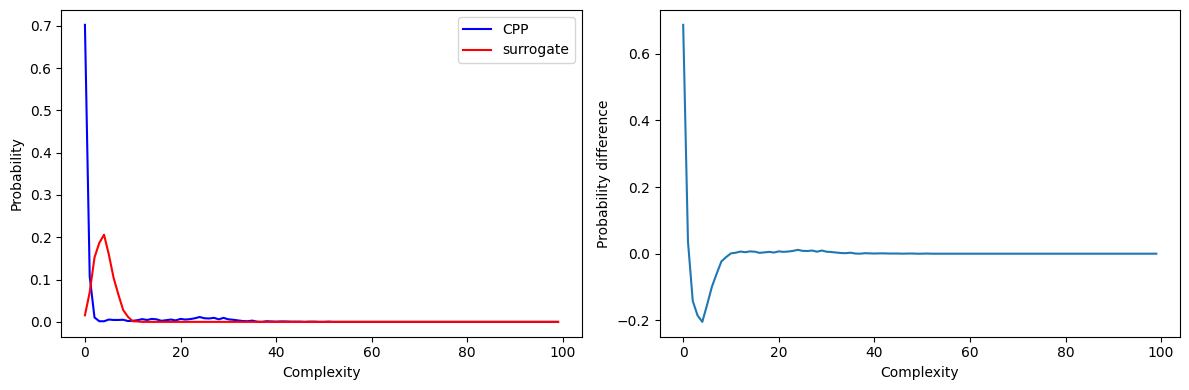

In [68]:
# Generation of surrogates
surr_sts = []

for st in cpp:
    surr_sts.append(surr.randomise_spikes(st)[0])

# Computation of the Complexity Distributions

def compute_complexity_distribution(spiketrains, bin_size):
    n = len(spiketrains)
    complexity = stats.Complexity(spiketrains, bin_size=bin_size, binary=True)
    dist = complexity.pdf().flatten().magnitude
    return np.concatenate([dist, np.zeros(n - len(dist))])

dist_surr = compute_complexity_distribution(surr_sts, binsize)

dist_diff = dist_cpp - dist_surr

# Plot the difference of the complexity distributions of the correlated and independent CPP
fig = plt.figure(figsize = (12, 4))

ax1 = plt.subplot(1, 2, 1)
ax1.set_xlabel('Complexity')
ax1.set_ylabel('Probability')
ax1.plot(np.arange(num_units), dist_cpp, color='blue', label="CPP")
ax1.plot(np.arange(num_units), dist_surr, color='red', label="surrogate")
ax1.legend()

ax2 = plt.subplot(1, 2, 2)
ax2.set_xlabel('Complexity')
ax2.set_ylabel('Probability difference')
ax2.plot(np.arange(num_units), dist_diff)

fig.tight_layout()
plt.show()

It is interesting to investigate the sensitivity of this measure to the binsize parameter, proceeding with the computation of complexity for different parameter setting, both of the correlated data and of the surrogates.
In particular it is possible to consider the coordinates of the second local maximum of the difference beetween complexity of correlated data and surrogate (purple line). This value is supposed to depend on the order of correlation of the data.

### Exercise

* Is it possible to infer a relation between the binsize and the time-precision of the synchrony embedded in the cpp model?


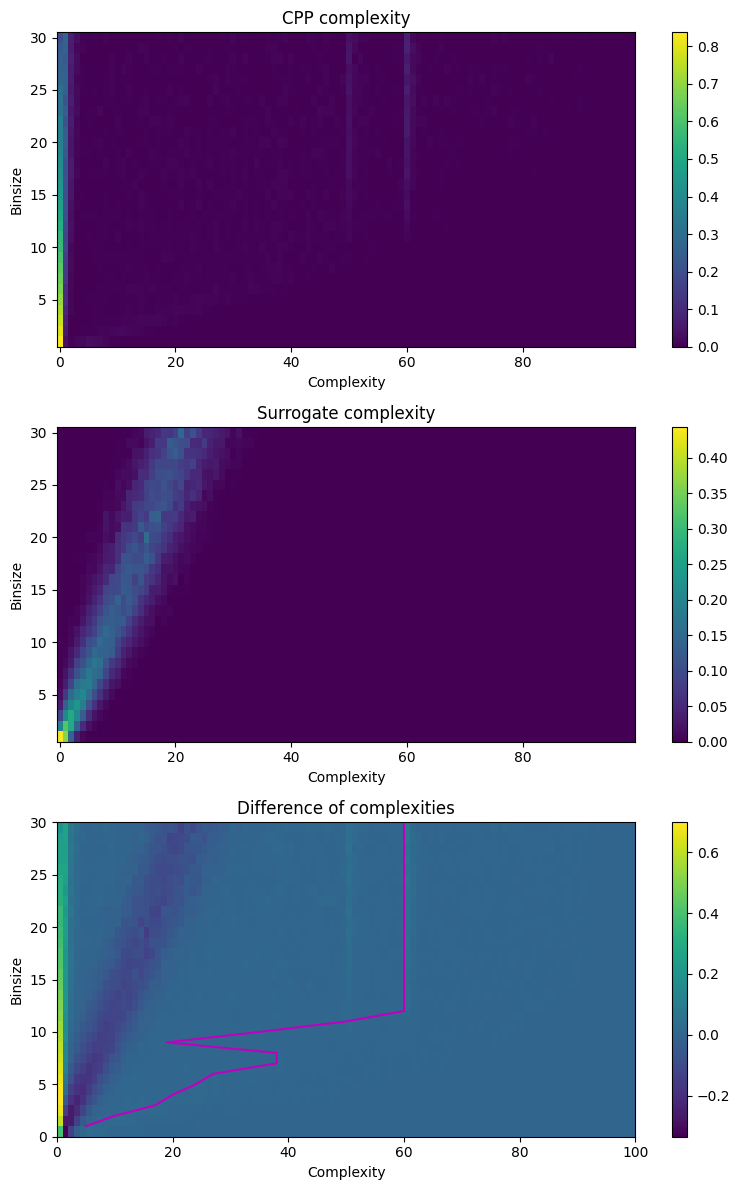

In [69]:
# Computate the complexity distributions of CPP and surrogates for different binsizes 
# and store the results in matrices
binsizes = np.arange(1, 31) * pq.ms
complexity_cpp_matrix = []
complexity_surr_matrix = []
diff_complexity_matrix = []
peak_pos = []
for i, binsize in enumerate(binsizes):
    complexity_cpp = compute_complexity_distribution(cpp, binsize)
    complexity_surr = compute_complexity_distribution(surr_sts, binsize)
    complexity_cpp_matrix.append(complexity_cpp)
    complexity_surr_matrix.append(complexity_surr)

    diff_complexity = complexity_cpp - complexity_surr
    diff_complexity_matrix.append(diff_complexity)

    trough_pos = np.argmin(diff_complexity)
    peak_pos.append(trough_pos + np.argmax(diff_complexity[trough_pos:]))

complexity_cpp_matrix = np.array(complexity_cpp_matrix)
complexity_surr_matrix = np.array(complexity_surr_matrix)
diff_complexity_matrix = np.array(diff_complexity_matrix)

complexities = np.arange(complexity_cpp_matrix.shape[1])

# Plot the complexity matrices
fig = plt.figure(figsize=(8, 12))

ax1 = plt.subplot(3, 1, 1)
ax1.set_title('CPP complexity')
ax1.set_xlabel('Complexity')
ax1.set_ylabel('Binsize')
im = ax1.pcolormesh(complexities, binsizes, complexity_cpp_matrix)
plt.colorbar(im)

ax2 = plt.subplot(3, 1, 2)
ax2.set_title('Surrogate complexity')
ax2.set_xlabel('Complexity')
ax2.set_ylabel('Binsize')
im = ax2.pcolormesh(complexities, binsizes, complexity_surr_matrix)
plt.colorbar(im)

ax3 = plt.subplot(3, 1, 3)
ax3.set_title('Difference of complexities')
ax3.set_xlabel('Complexity')
ax3.set_ylabel('Binsize')
im = ax3.pcolormesh(diff_complexity_matrix)
plt.colorbar(im)
ax3.plot(peak_pos, binsizes, 'm')

fig.tight_layout()
plt.show()

## 3.3 SPADE
SPADE (Spike PAttern Detection and Evaluation) is a method to detect spatio-temporal patterns (STPs) in massively parallel spike trains.
It consists of a mining step, detection of candidate patterns, and two statistical test steps, evaluating significance of the patterns (see Quaglio et al. 2017).
The pattern here is defined as exact spike synchrony across neurons participating in an assembly, without any temporal delay or jitter.

### 3.3.1 Insertion of STPs into independent artificial data
Again we generate appropriate artificial data in order to understand the method through applications.
Here we generate the data by combining two different CPPs: the first modeling the neurons participating in an assembly, the second modeling independent data for the remaining neurons.


In [ ]:
# Spike train parameters
num_units = 100      
rate = 2 * pq.Hz 
trial_duration = 10 * pq.s
# - parameters for the CPP model
assembly_size = 10
p_coinc = 0.05
jitter = 1 * pq.ms

# Analysis parameters
binsize_comp_dist = 1 * pq.ms

# Constduct the amplitude distribution for the CPP 
amp_dist_sip = np.zeros(assembly_size + 1) 
amp_dist_sip[1] = 1. - p_coinc
amp_dist_sip[assembly_size] = p_coinc

# Generate the CPP data
cpp_sp = stocmod.cpp(rate, amp_dist_sip, trial_duration, shift=jitter)

# Generate independent data and combine the two data sets
amp_dist_indep = [0, 1] + [0] * (num_units - assembly_size - 1)
cpp_sp.extend(stocmod.cpp(rate, amp_dist_indep, trial_duration))

# Compute the population histogram and the complexity distribution
complexity_cpp = stats.Complexity(cpp_sp, bin_size=binsize_comp_dist, binary=True)
pophist = complexity_cpp.time_histogram
dist_cpp = complexity_cpp.pdf().flatten().magnitude
dist_cpp = np.concatenate([dist_cpp, np.zeros(num_units - len(dist_cpp))])

# Plot the results
fig = plt.figure(figsize=(12, 5))

ax1 = plt.subplot(2, 2, 1)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Unit ID')
for i, st in enumerate(cpp_sp):
    ax1.plot(st.rescale('ms').magnitude, [i + 1] * len(st), '.', ms=1, color='black')

ax2 = plt.subplot(2, 2, 3, sharex=ax1)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Count')
ax2.plot(pophist.times.rescale('ms'), pophist[:, 0], lw=0.5)

ax3 = plt.subplot(2, 2, 2)
ax3.set_xlabel('Complexity')
ax3.set_ylabel('Probability')
ax3.bar(np.arange(len(amp_dist_sip)), amp_dist_sip, label='amplitude distrib.')
ax3.legend()

ax4 = plt.subplot(2, 2, 4)
ax4.set_xlabel('Complexity')
ax4.set_ylabel('Probability')
ax4.plot(np.arange(num_units), dist_cpp, '.-', label='complexity distrib.')
ax4.legend()

fig.tight_layout()
plt.show()

### 3.3.2 Application of SPADE

Now we move to the application of the method to the artificially generated data. The goal is to detect the embedded patterns with SPADE, and visualize them.
If needed, look at the documentation of SPADE.
* Apply the method and plot the detected patterns.
* Display the output of the method and examine the contents.
* Is there a relation between `binsize` and the time precision of the synchrony embedded in the CPP (i.e., `jitter` parameter in the previous code cell)?
* Play with the parameters of the method. For example, what happens if the number of surrogates is set to zero (no statistical evaluation)? What happens if `psr_param` is set to `None` (no pattern set reduction)?
* (Optional) Try to inject a second pattern, by generating a second CPP with the appropriate number of components, and apply the method to this data.

In [ ]:
# Analysis parameters
binsize = 5 * pq.ms
winlen = 5
n_surr = 20
significance_level = 0.01

# Apply SPADE to the data
# spade_result = spade.spade(cpp_sp, binsize, winlen, output_format='patterns', n_surr=n_surr, alpha=significance_level, psr_param=[0,0,0])
spade_result = spade.spade(cpp_sp, binsize, winlen, output_format='patterns', n_surr=n_surr, alpha=significance_level, psr_param=None)

# Plot the result
fig = plt.figure(figsize=(12, 5))

ax = plt.subplot(111)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Unit index')

i_pattern_unit = []
for i_pattern, pattern in enumerate(spade_result['patterns']):
    for i, t in enumerate(pattern['times'].magnitude):
        spikes_times = [t] + [t+l for l in pattern['lags'].magnitude]
        if i == 0:
            ax.plot(spikes_times, pattern['neurons'], 'o-', color=f'C{i_pattern}', label=f'Pattern {i_pattern}: {pattern["signature"]}')
        else:
            ax.plot(spikes_times, pattern['neurons'], 'o-', color=f'C{i_pattern}')
    i_pattern_unit.extend(pattern['neurons'])
i_pattern_unit = np.unique(i_pattern_unit)

for i_unit in i_pattern_unit:
    st = cpp_sp[i_unit]
    ax.plot(st.rescale('ms'), [i_unit]*len(st), '.k')

ax.legend()

fig.tight_layout()
plt.show()

In [ ]:
spade_result